### Imports

If working in a [suite2p](https://github.com/MouseLand/suite2p) conda environment initialized according to the guide [here](https://github.com/MouseLand/suite2p#installation), using the provided [environment.yml](https://github.com/MouseLand/suite2p/blob/main/environment.yml), all of these dependencies should all be present, with the exception of `skimage`. To obtain it, execute `conda install scikit-image` in your terminal while your **suite2p** conda environment is active.

In [1]:
import os
import re
import shutil
import sys

import numpy as np
import torch
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
from matplotlib.patches import Rectangle

from skimage import io
from skimage import measure
from tifffile import imsave

from scipy import signal
from scipy.interpolate import interp2d
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import cluster

# local imports
from image_arrays import *
from s2p_packer import unpack_hdf

sys.path.append('../python-analysis')
import torch_clustering as clorch
import cluster_ae_builds as builds
from conv1d_deep_cluster import Conv1dDeepClusterer

### Activate interactive plotting
By default, inline plots are static. Here we specify one of two options (comment out the undesired command) that will open plots with GUI controls for us.
- **qt ->** figures opened in windows outside the notebook
- **notebook ->** figures within notebook underneath generating cell.

In [2]:
# %matplotlib qt 
%matplotlib notebook

### Paths describing folder structure used for loading in videos and data archives
These, along with naming of the files when they come up, should be altered to align with your setup.

In [3]:
base_path = "/mnt/Data/prerna_noise/"
# data_path = base_path + "second_batch/originals/"
# data_path = base_path + "second_batch/bigger_diam/"
data_path = base_path + "2021_02_05/DD/"
s2p_path = data_path + "s2p/"

### Load noise stimulus
Here it is expected to be in `base_path`. Also, create an upsampled version (not currently in use, could be commented out).

In [4]:
raw_noise = io.imread(os.path.join(base_path, "noise_stimulus.tif"))
raw_noise = raw_noise.transpose(0, 2, 1) / 255

# physical dimensions (microns)
stim_width = 400
stim_height = 400

# 60Hz for 60s after 10s delay
noise_frames, noise_cols, noise_rows = raw_noise.shape
noise_xaxis = np.arange(noise_frames) * (1 / 60) + 10.

print("raw noise shape:", raw_noise.shape)

raw noise shape: (3600, 16, 16)


### Display noise stimulus used for this experiment / analysis
Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`).

<IPython.core.display.Javascript object>


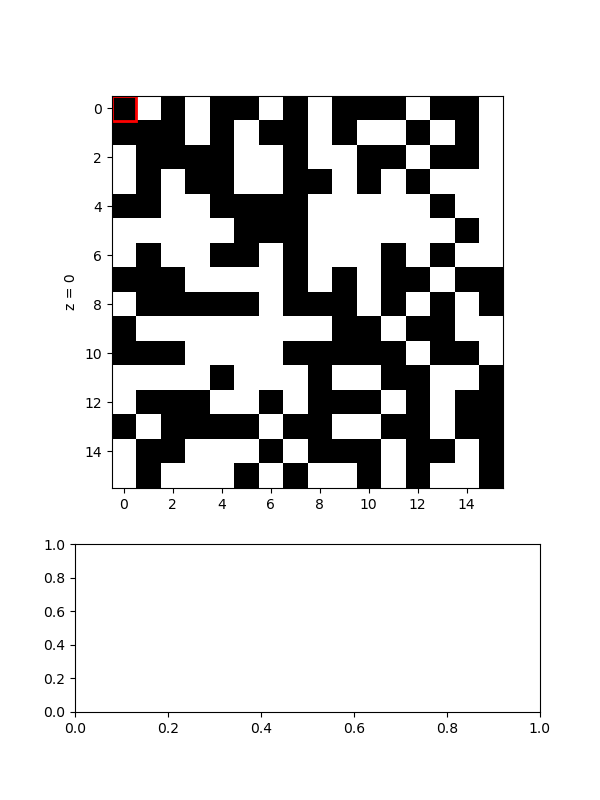

In [5]:
raw_noise_plot = StackExplorer(
    raw_noise,
    zaxis=noise_xaxis,
    delta=10,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
raw_noise_plot.ax[1].set_xlabel("Time (s)")
raw_noise_plot.ax[1].set_ylabel("Pixel Value")

raw_noise_plot.fig.show()

### List tiff files found in the directory indicated by `data_path`

#### Note:
**DD ->** distal. **X** 71.7um, **Y** 28.94um

**PD ->** proximal. **X** 71.7um, **Y** 30.9um

In [6]:
fnames = [
    f for f in os.listdir(data_path) 
    if (f.endswith(".tiff") or f.endswith(".tif"))
]

print("files:")
for f in fnames:
    print("  %s" % f)

files:


### Select (and display) recording to analyse here.
Set `ex_name` to the name shared by the desired `.tif` (found in `data_path`) and the `.h5` (found in `s2p_path`). Use scroll wheel to cycle through the frames of the video (in frame steps set by the `delta` paramater of `StackExplorer`). While moving around the ROI, one may left-click to lock it in the current position, allowing interaction with the z-projection axis underneath.

In [7]:
ex_name = "400um"
with h5.File(os.path.join(s2p_path, ex_name + ".h5"), "r") as f:
    ex_s2p = unpack_hdf(f)
    
# physical dimensions (in microns)
rec_width = 71.7
rec_height = 28.94

In [8]:
shared_keys = {"denoised", "masks", "pixels"}

names = [n for n in ex_s2p.keys() if n not in shared_keys]
trials = {i: ex_s2p[n] for i, n in enumerate(names)}

recs = np.stack([ex_s2p[n]["recs"] for n in names], axis=0)
fneu = np.stack([ex_s2p[n]["Fneu"] for n in names], axis=0)
n_trials, n_rois, n_pts = recs.shape

tiff_path = os.path.join(data_path, "200um")

stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)

recs_xaxis = np.arange(stacks.shape[1]) * 0.05  # 20Hz sampling rate

<IPython.core.display.Javascript object>


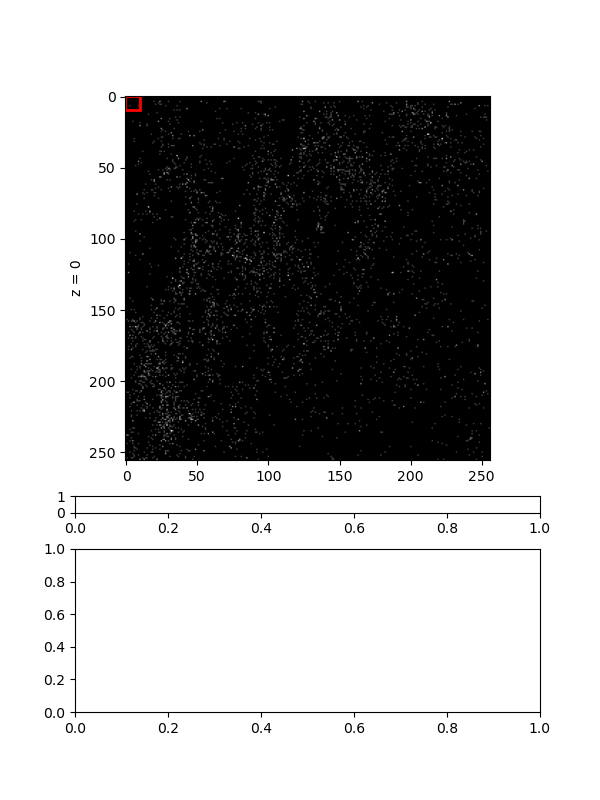

Recording shape: (1700, 256, 256)


In [9]:
stacks = np.stack(
    [
        io.imread(os.path.join(tiff_path, f))
        for f in os.listdir(tiff_path) 
        if (f.endswith(".tiff") or f.endswith(".tif"))
    ],
    axis=0
)

stacks_plot = StackExplorer(
    stacks,
    zaxis=recs_xaxis,
    delta=5,
    roi_sz=10,
    vmin=0,
    figsize=(6, 8)
)
stacks_plot.ax[1].set_xlabel("Time (s)")
stacks_plot.ax[1].set_ylabel("Pixel Value")

print("Recording shape:", stacks[0].shape)
stacks_plot.fig.show()

### Pixel map ROIs generated by suite2p
Use scroll wheel to cycle through ROIs.

<IPython.core.display.Javascript object>


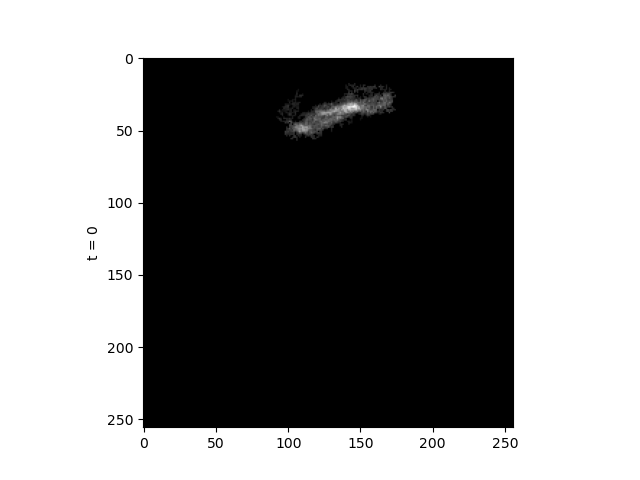

In [10]:
mask_stack = ex_s2p["masks"].transpose(2, 0, 1)
mask_stack_fig, mask_stack_ax = plt.subplots(1)
mask_stack_plot = StackPlotter(
    mask_stack_fig,
    mask_stack_ax,
    mask_stack,
    delta=1
)
mask_stack_fig.show()

### Denoise and signal-noise normalize ROI responses

In [11]:
# subtract out extracted neuropil signal (denoising)
# recs = recs - fneu * 0.7

# normalize to noise and remove offset
recs /= np.var(recs[:, :, 40:198], axis=2).reshape(*recs.shape[:2], 1)
recs -= np.mean(recs[:, :, 40:198], axis=2).reshape(*recs.shape[:2], 1)

### Explore signals from ROIs, and peak finding parameters
Use scroll wheel to cycle between ROIs, and the input boxes below to
adjust parameters for the peak finding algorithm (see `scipy.signal.find_peaks` for more documentation).

- **prominence:** target difference between a peak and its surrounding mean
- **width:** number of points the value must remain within the fractional **tolerance** range of the peak in order to be considered
- **distance:** minimum allowable interval between peak candidates

In [12]:
peak_explorer = PeakExplorer(
    recs_xaxis, 
    recs[0],
    prominence=1,
    width=2,
    tolerance=.5,
    distance=1
)

<IPython.core.display.Javascript object>

### Create response triggered average of stimulus movie, and use a rough transformation of the cell ROI to calculate the average intensity over time.
- `roi_idx` sets the ROI used to generate the triggered stimulus. Make use of the mask and beam scrollers above to pick out ROIs that you might want to do this with
- `lead` sets the time (in seconds) to use preceding each threshold passing event.
- peak finding parameters correspond to those above, set them here in order to influence the stimulus triggered window calculation.
- `max_prominence` sets a clip off point for peaks, such that errantly large events do not completely wash out the rest (due to prominence scaling using softmax). This is optional, and can be set to `None` or commented out from the arguments given to `avg_trigger_window`.

The dotted blue outline represents the relative postion and size of the recording scan field. This can be removed by simply changing the value in the conditional to `0` (or `False`). 

In [66]:
roi_idx = 44
lead = 1.2  # length of triggered average movie (seconds before peak)

prominence = 1.5        # difference between peaks and their surroundings
peak_width = 2         # minimum number of points (within tolerance)
peak_tolerance = .5    # ratio value can drop from peak within width
min_peak_interval = 1  # number of points required between peaks
max_prominence = 4     # clip to avoid dominance by errant peaks
start_time = 30        # time to begin using peaks for triggered average
end_time = None        # cutoff time for considering peaks

lead_frames = nearest_index(noise_xaxis, np.min(noise_xaxis) + lead)

# NOTE: ROIs without events will be thrown out, so pos_to_roi must
# be used from here on for lining up ROI numbers with the index in
# lead_stacks and derived arrays
lead_stacks, legal_idxs = [], []
count, pos_to_roi, roi_to_pos = 0, [], {}

for i in range(n_rois): 
    peak_idxs, peak_proms = find_peaks(
        recs[:, i],
        prominence=prominence,
        width=peak_width,
        rel_height=peak_tolerance,
        distance=min_peak_interval
    )
    
    windows, legals = [], []
    for j in range(n_trials):
        trig, idxs = avg_trigger_window(
            noise_xaxis, 
            raw_noise,
            recs_xaxis,
            recs[j][i],
            lead,
            peak_idxs[j],
            prominences=peak_proms[j],
            max_prominence=max_prominence,
            nonlinear_weighting=True,
            start_time=start_time,
            end_time=end_time,
        )
        windows.append(trig)
        legals.append(idxs)

    # if there are any trials without triggers, replace with blank
    if all(map(lambda l: len(l) > 0, legals)):
        lead_stacks.append(np.stack(windows, axis=0))
        legal_idxs.append(legals)
        pos_to_roi.append(i)
        roi_to_pos[i] = count
        count += 1

# shape is [n_kept_rois, n_trials, lead_frames, n_cols, n_rows]
lead_stacks = np.stack(lead_stacks, axis=0)
mean_lead_stacks = np.mean(lead_stacks, axis=1)
lead_xaxis = np.linspace(lead_frames * (-1 / 60), 0, lead_frames)
n_kept_rois = len(pos_to_roi)

number of peaks used: [61, 105, 88]


<IPython.core.display.Javascript object>


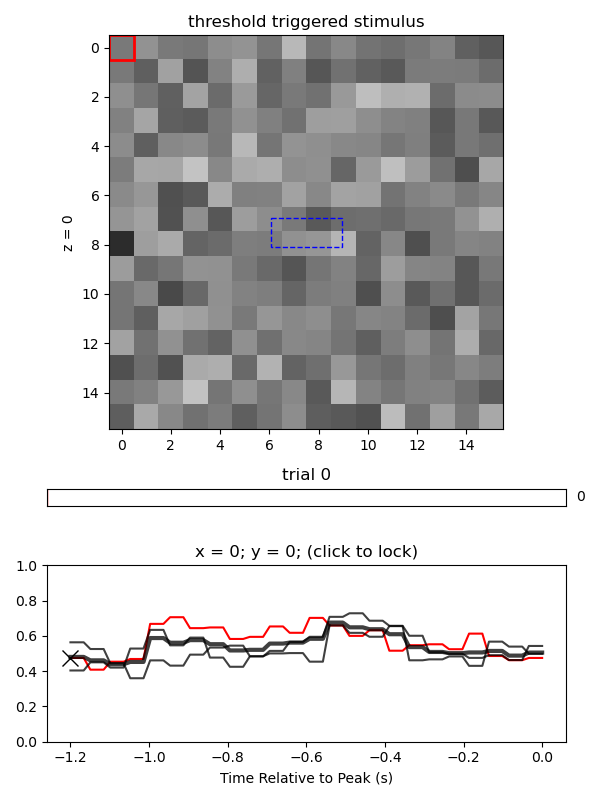

In [62]:
roi_idx = 44
roi_pos = roi_to_pos[roi_idx]
n_legals = [len(l) for l in legal_idxs[roi_pos]]
print("number of peaks used:", n_legals)

lead_stack_plot = StackExplorer(
    lead_stacks[roi_pos],
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
lead_stack_plot.stack_ax.set_title("threshold triggered stimulus")
lead_stack_plot.beam_ax.set_xlabel("Time Relative to Peak (s)")
lead_stack_plot.fig.tight_layout()

# outline of scan field (guide for where to look for receptive field)
# NOTE: PD scans are offset (stims is centered to DD scan field)
if 1:
    x_corner_phys = (stim_width - rec_width) / 2
    y_corner_phys = (stim_height - rec_height) / 2
    x_corner_scaled = x_corner_phys / stim_width * raw_noise.shape[2]
    y_corner_scaled = y_corner_phys / stim_height * raw_noise.shape[1]

    field = Rectangle(
        (x_corner_scaled - .5, y_corner_scaled - .5),  # grid offset
        rec_width / stim_width * raw_noise.shape[2], 
        rec_height / stim_height * raw_noise.shape[1], 
        fill=False,
        color="blue",
        linewidth=1,
        linestyle="--"
    )
    lead_stack_plot.ax[0].add_patch(field)

lead_stack_plot.fig.show()

### Rough "receptive field" map via response vs baseline subtraction

<IPython.core.display.Javascript object>


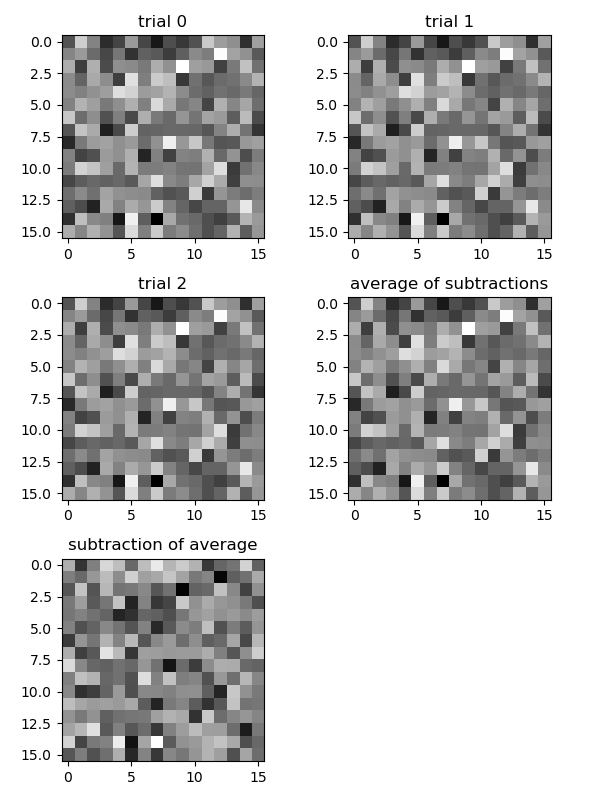

In [63]:
# bsln_t0 = -.500
# bsln_t1 = -.400
# resp_t0 = -.250
# resp_t1 = -.150

# bsln_t0 = -.200
# bsln_t1 = -.150
# resp_t0 = -.75
# resp_t1 = -.25

bsln_t0 = -.400
bsln_t1 = -.350
resp_t0 = -.150
resp_t1 = -.100

bsln_mask = (bsln_t0 <= lead_xaxis) * (lead_xaxis <= bsln_t1)
bsln = np.mean(lead_stacks[roi_pos, :, bsln_mask], axis=1)
resp_mask = (resp_t0 <= lead_xaxis) * (lead_xaxis <= resp_t1)
resp = np.mean(lead_stacks[roi_pos, :, resp_mask], axis=1)

sub = resp - bsln
avg_sub = np.mean(sub, axis=0)
vmin = np.min(sub)
vmax = np.max(sub)

avg_lead_bsln = np.mean(mean_lead_stacks[roi_pos, bsln_mask], axis=0)
avg_lead_resp = np.mean(mean_lead_stacks[roi_pos, resp_mask], axis=0)
avg_lead_sub = avg_lead_bsln - avg_lead_resp

ntrials = sub.shape[0]
ncols = 2
nrows = np.ceil((ntrials + 2) / ncols).astype(np.int)
sub_field_fig, sub_field_ax = plt.subplots(nrows, ncols, figsize=(6, 8))
i = 0
for row in sub_field_ax:
    for a in row:
        if i < ntrials:
            a.imshow(sub[i], cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("trial %i" % i)
        elif i == ntrials:
            a.imshow(avg_sub, cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("average of subtractions")
        elif i == ntrials + 1:
            a.imshow(avg_lead_sub, cmap="gray", vmin=vmin, vmax=vmax)
            a.set_title("subtraction of average")
        else:
            a.set_visible(False)
        i += 1
        
sub_field_fig.tight_layout()

### Randomly triggered stimulus for comparison

Sampling N windows from the stimulus randomly, where N is the number of peaks found in the target ROI above (trial with lowest number of legal peaks is used). This is presented for comparison to get a feel for how variable the averages are with this number of samples, as well as to see how often "receptive field" like signals emerge by chance. 

<IPython.core.display.Javascript object>


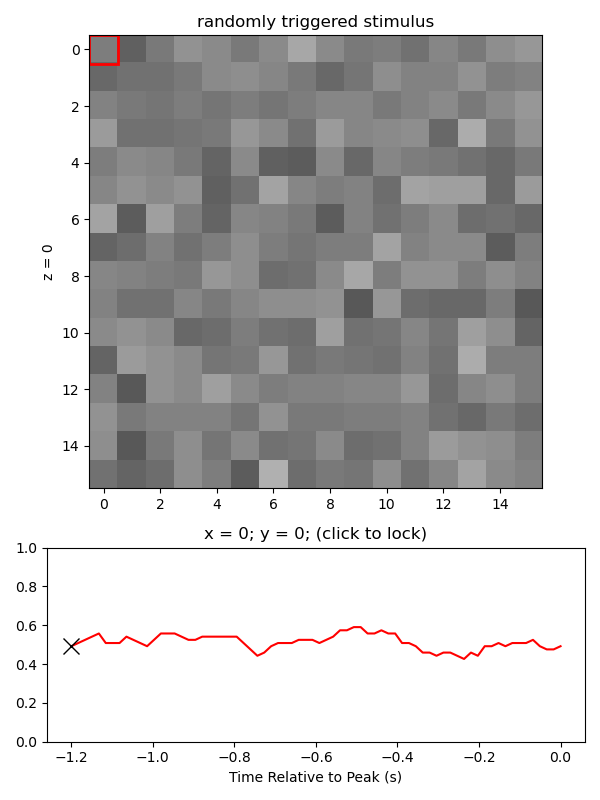

In [64]:
ts = np.random.uniform(
    low=(np.min(noise_xaxis) + lead), 
    high=np.max(noise_xaxis),
    size=min(n_legals)
)
random_lead_stack = np.mean([
    lead_window(noise_xaxis, raw_noise, t, lead) for t in ts
], axis=0)

random_lead_stack_plot = StackExplorer(
    random_lead_stack,
    zaxis=lead_xaxis,
    delta=1,
    roi_sz=1,
    vmin=0,
    vmax=1,
    figsize=(6, 8)
)
random_lead_stack_plot.ax[0].set_title("randomly triggered stimulus")
random_lead_stack_plot.ax[1].set_xlabel("Time Relative to Peak (s)")
random_lead_stack_plot.fig.tight_layout()

<IPython.core.display.Javascript object>


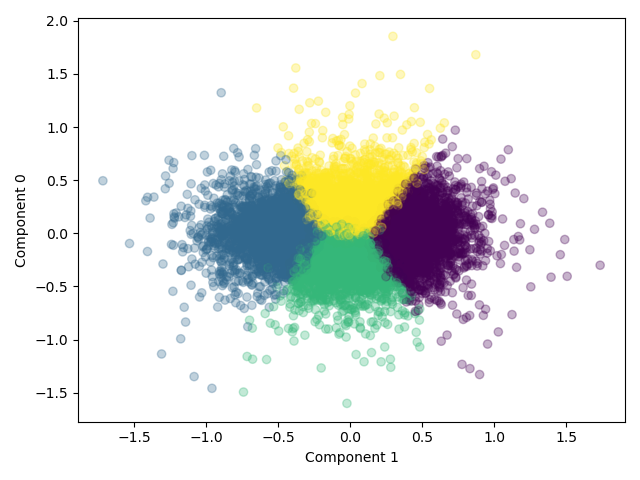

pca_k_lbls shape: (71, 16, 16)


In [67]:
pca = PCA()
k = 4
start_frame = 0

trunc_mean_lead_stacks = mean_lead_stacks[:, start_frame:]


reduced_trig_avg = pca.fit_transform(
    trunc_mean_lead_stacks.transpose(1, 0, 2, 3).reshape(
        trunc_mean_lead_stacks.shape[1], -1
    ).T
)
_, pca_k_lbls_flat, _ = cluster.k_means(reduced_trig_avg, k)

pca_trig_fig, pca_trig_ax = plt.subplots(1)
pca_trig_ax.scatter(
    reduced_trig_avg[:, 0],
    reduced_trig_avg[:, 1],
    alpha=.3,
    c=pca_k_lbls_flat,
)

pca_trig_ax.set_ylabel("Component 0")
pca_trig_ax.set_xlabel("Component 1")
pca_trig_fig.tight_layout()

pca_k_lbls = pca_k_lbls_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
print("pca_k_lbls shape:", pca_k_lbls.shape)

<IPython.core.display.Javascript object>


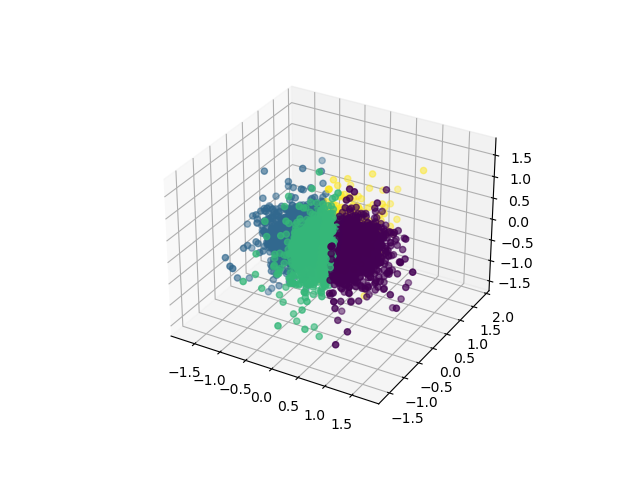

In [68]:
pca_3d_trig_fig = plt.figure()
pca_3d_trig_ax = pca_3d_trig_fig.add_subplot(111, projection='3d')

pca_3d_trig_ax.scatter(
    reduced_trig_avg[:, 0],
    reduced_trig_avg[:, 1],
    reduced_trig_avg[:, 2],
    c=pca_k_lbls_flat,
)

<IPython.core.display.Javascript object>


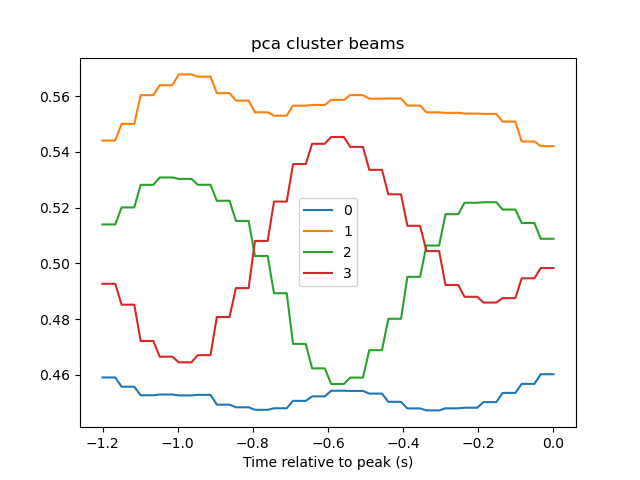

avg groups: [4714, 3606, 4998, 4858]


In [79]:
# TODO: this flat way is not the correct way to go. See shake of lbls
# above. That's a start
trans_mean_leads = mean_lead_stacks.transpose(0, 2, 3, 1)
avg_cluster_beams = np.stack(
    [
        np.mean(trans_mean_leads[pca_k_lbls == i], axis=0) 
         for i in range(k)
    ],
    axis=0
)

cluster_beams_fig, cluster_beams_ax = plt.subplots(1)
for i, b in enumerate(avg_cluster_beams):
    cluster_beams_ax.plot(lead_xaxis, b, label="%i" % i)

cluster_beams_ax.legend()

cluster_beams_ax.set_title("pca cluster beams")
cluster_beams_ax.set_xlabel("Time relative to peak (s)")

print("avg groups:", [np.sum(pca_k_lbls == i) for i in range(k)])

In [70]:
# TODO: replace with stack plot of the maps?
# fw, aw = plt.subplots(1)
# aw.imshow(avg_k_lbls.reshape(16, 16), cmap="jet")

<IPython.core.display.Javascript object>

NameError: name 'avg_k_lbls' is not defined

In [73]:
def ae_build_1():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 64, 'kernel': 11, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 64, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 9, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 6},
    ])
    return autoencoder


def ae_build_2():
    """"""
    autoencoder = Conv1dDeepClusterer([
        {
            'type': 'conv', 'in': 1, 'out': 128, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 128, 'out': 256, 'kernel': 5, 'stride': 2,
            'dilation': 1, 'causal': True,
        },
        {
            'type': 'conv', 'in': 256, 'out': 128, 'kernel': 18, 'stride': 1,
            'pad': 'valid'
        },
        {'type': 'squeeze'},
        {'type': 'dense', 'in': 128, 'out': 6},
    ])
    return autoencoder

epoch: 0 n_batches: 45
cost: 0.254342
cost: 0.006986
epoch: 1 n_batches: 45
cost: 0.006545
cost: 0.005403
epoch: 2 n_batches: 45
cost: 0.006130
cost: 0.006055
epoch: 3 n_batches: 45
cost: 0.005787
cost: 0.005648
epoch: 4 n_batches: 45
cost: 0.006422
cost: 0.007114


<IPython.core.display.Javascript object>


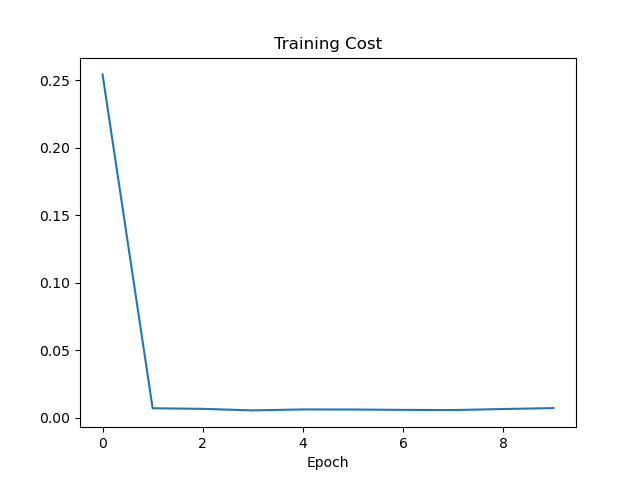

In [111]:
# TODO: Make and autoencoder build here that will fit the size of
# the lead stacks.

# build network
autoencoder = ae_build_2()
# autoencoder = builds.ae_build_14()

x = mean_lead_stacks.transpose(1, 0, 2, 3).reshape(
    lead_frames, 1, -1
).transpose(2, 1, 0)

# fit network
cost_fig = autoencoder.fit(
    x,
    k, 
    lr=1e-4,
    epochs=5,
    batch_sz=400,
    cluster_alpha=.05,
    clust_mode='KLdiv',
#     clust_mode='Km',
#     clust_mode='Cal',
    show_plot=True,
)

In [112]:
torch_reduced = autoencoder.get_reduced(x)

hard_centres, hard_clusters, _ = clorch.hard_kmeans(
    torch.from_numpy(torch_reduced), k)
hard_centres = hard_centres.cpu().numpy()
hard_clusters_flat = hard_clusters.cpu().numpy()
hard_clusters = hard_clusters_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
print(
    "hard torch groups:", 
    [np.sum(hard_clusters_flat == i) for i in range(k)]
)

soft_centres, soft_clusters, _ = clorch.soft_kmeans(
    torch.from_numpy(torch_reduced), k)
soft_centres = soft_centres.cpu().numpy()
soft_clusters_flat = soft_clusters.cpu().numpy()
soft_labels_flat = np.argmax(soft_clusters_flat, axis=1)
soft_clusters = soft_clusters_flat.reshape(
    n_kept_rois, noise_cols, noise_rows, -1
)
soft_labels = soft_labels_flat.reshape(
    n_kept_rois, noise_cols, noise_rows
)
print(
    "soft torch groups:", 
    [np.sum(soft_labels_flat == i) for i in range(k)]
)

hard torch groups: [2228, 5516, 5688, 4744]
soft torch groups: [10994, 7140, 0, 42]


<IPython.core.display.Javascript object>


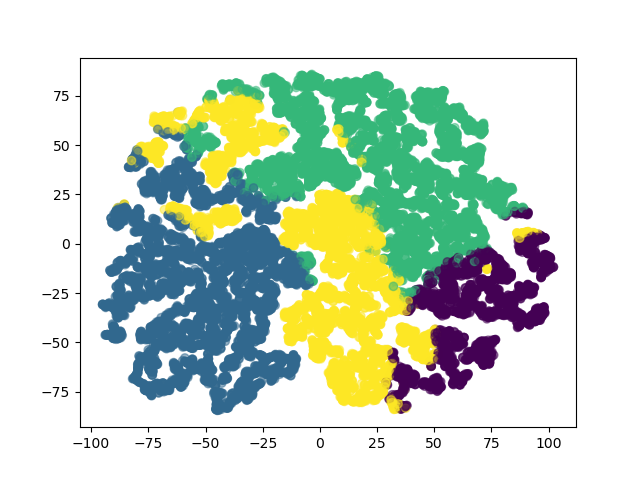

In [113]:
if torch_reduced.shape[1] > 2:
    # also, reduce the cluster centres (TSNE must do all at once)
    reduced_centres = TSNE(
        n_components=2, 
        perplexity=20, 
    ).fit_transform(
        np.concatenate([torch_reduced, hard_centres], axis=0)
    )
    # split samples and centres
    tsne_reduced = reduced_centres[:-hard_centres.shape[0], :]
    tsne_centres = reduced_centres[-hard_centres.shape[0]:, :]
    del reduced_centres

torch_reduced_fig, torch_reduced_ax = plt.subplots(1)

torch_reduced_ax.scatter(
    tsne_reduced[:, 0], 
    tsne_reduced[:, 1], 
    c=hard_clusters, 
    alpha=.5
)

/home/geoff/miniconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3373: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/geoff/miniconda3/envs/suite2p/lib/python3.7/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in true_divide
  ret, rcount, out=ret, casting='unsafe', subok=False)


<IPython.core.display.Javascript object>


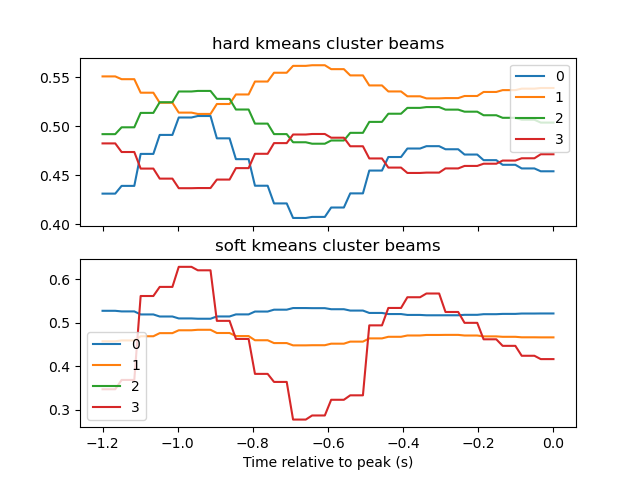

Text(0.5, 0, 'Time relative to peak (s)')

In [114]:
hard_cluster_beams = [
    np.mean(trans_mean_leads[hard_clusters == i], axis=0) 
    for i in range(k)
]
soft_cluster_beams = [
    np.mean(trans_mean_leads[soft_labels == i], axis=0) 
    for i in range(k)
]

torch_beams_fig, torch_beams_ax = plt.subplots(2, sharex=True)
for i, (hb, sb) in enumerate(zip(hard_cluster_beams, soft_cluster_beams)):
    torch_beams_ax[0].plot(lead_xaxis, hb, label="%i" % i)
    torch_beams_ax[1].plot(lead_xaxis, sb, label="%i" % i)

for a in torch_beams_ax:
    a.legend()
    
torch_beams_ax[0].set_title("hard kmeans cluster beams")
torch_beams_ax[1].set_title("soft kmeans cluster beams")
torch_beams_ax[1].set_xlabel("Time relative to peak (s)")

In [115]:
# TODO: stack explorer to go through each ROI?
# hard_map_fig, hard_map_ax = plt.subplots(1)
# hard_map_ax.imshow(hard_clusters.reshape(16, 16), cmap="jet")

In [ ]:
# TODO: This is well suited to scatter plots incorporating the soft
# weights. Since the argmax at the end is not assigning anything to a
# non-response cluster (unlike in hard kmeans), there should be plenty
# of low confidence ones (close in the two active ones, or spread)
# Should help determine whether a threshold of confidence will help
# my cause of reducing this data effectively

# soft_map_fig, soft_map_ax = plt.subplots(1)
# soft_map_ax.imshow(soft_labels.reshape(16, 16), cmap="jet")

<IPython.core.display.Javascript object>


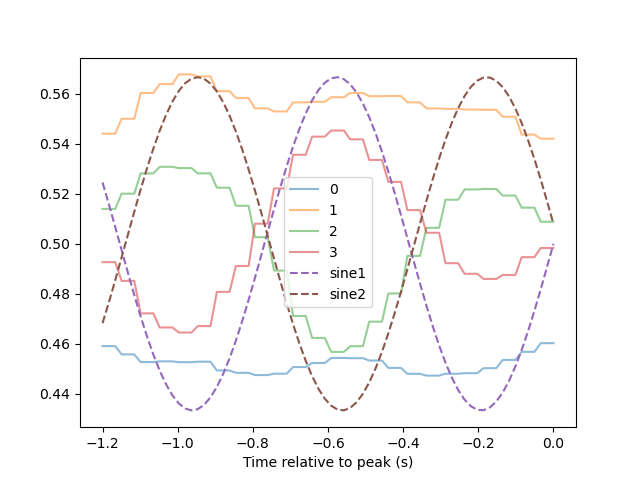

Text(0.5, 0, 'Time relative to peak (s)')

In [123]:
sine_test_fig, sine_test_ax = plt.subplots(1)
for i, b in enumerate(avg_cluster_beams):
    sine_test_ax.plot(lead_xaxis, b, label="%i" % i, alpha=.5)

sine1 = np.sin((lead_xaxis + .0) * 2 * np.pi * 1.3)
sine2 = np.sin((lead_xaxis + .37) * 2 * np.pi * 1.3)
early_sine1 = np.concatenate([sine1[:36], np.zeros(36)])
early_sine2 = np.concatenate([sine2[:36], np.zeros(36)])
late_sine1 = np.concatenate([np.zeros(36), sine1[36:]])
late_sine2 = np.concatenate([np.zeros(36), sine2[36:]])
pos_lin = np.arange(lead_frames) / lead_frames - .5
neg_lin = -np.arange(lead_frames) / lead_frames + .5

lines = np.stack(
    [
        sine1, 
        sine2, 
        pos_lin, 
        neg_lin, 
        early_sine1, 
        early_sine2,
        late_sine1, 
        late_sine2,
    ], 
    axis=0
)

sine_test_ax.plot(lead_xaxis, sine1 / 15 + .5, linestyle="--", label="sine1")
sine_test_ax.plot(lead_xaxis, sine2 / 15 + .5, linestyle="--", label="sine2")
# sine_test_ax.plot(lead_xaxis, pos_lin, linestyle="--", label="pos")
# sine_test_ax.plot(lead_xaxis, neg_lin, linestyle="--", label="neg")

# sine_test_ax.set_ylim(.4, .6)
sine_test_ax.legend()
sine_test_ax.set_xlabel("Time relative to peak (s)")

<IPython.core.display.Javascript object>


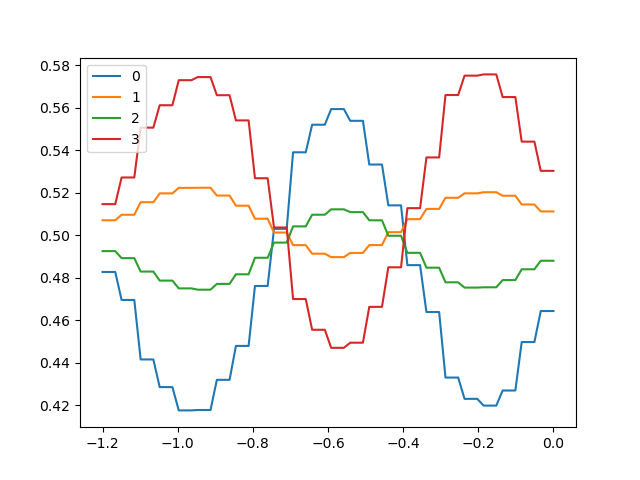

line groups: [1924, 7025, 6854, 2373]


In [129]:
line_corrs = np.array([
    np.concatenate([np.correlate(b, l) for l in lines])
    for b in np.squeeze(x)
])
pca_line_corrs = pca.fit_transform(line_corrs)

line_k_centres, line_k_lbls, _ = cluster.k_means(pca_line_corrs, k)
line_cluster_beams = [
    np.mean(s[line_k_lbls == i], axis=0) for i in range(k)
]

line_beams_fig, line_beams_ax = plt.subplots(1)
for i, b in enumerate(line_cluster_beams):
    line_beams_ax.plot(lead_xaxis, b, label="%i" % i)
line_beams_ax.legend()  

print("line groups:", [np.sum(line_k_lbls == i) for i in range(k)])

<IPython.core.display.Javascript object>


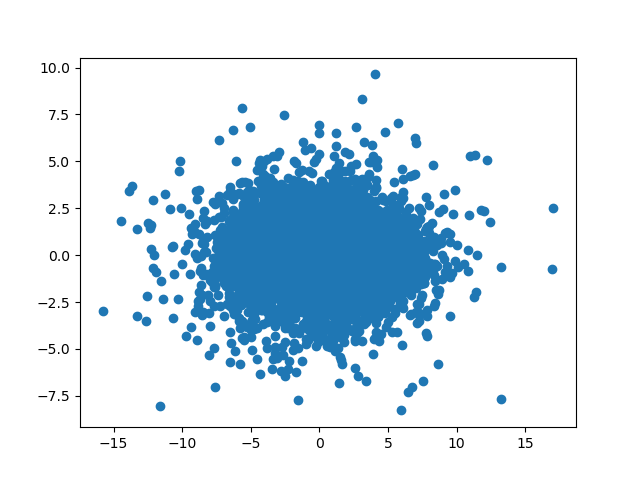

In [130]:
pca_lines_scatter_fig, pca_lines_ax = plt.subplots(1)
pca_lines_ax.scatter(pca_line_corrs[:, 0], pca_line_corrs[:, 1])

<IPython.core.display.Javascript object>


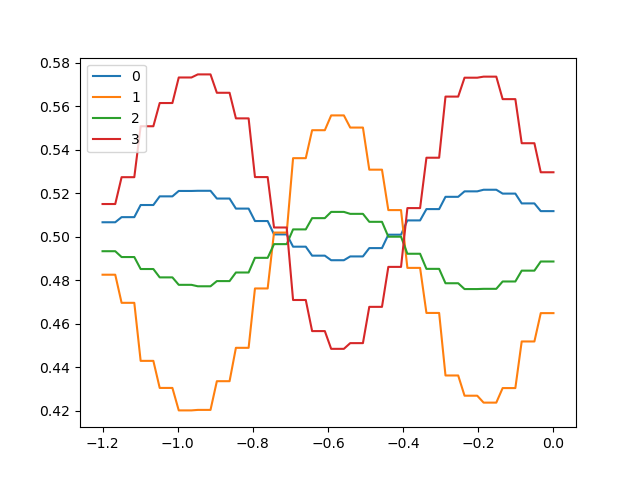

soft line groups: [6738, 2173, 6796, 2469]


In [131]:
# NOTE: The argmax of this soft kmeans seems to be pretty close to
# the result from scipy kmeans. Can probably use it in place so I
# don't have to duplicate like this.
soft_line_centres, soft_line_clusters, _ = clorch.soft_kmeans(
    torch.from_numpy(line_corrs), kk)
soft_line_centres = soft_line_centres.cpu().numpy()
soft_line_clusters = soft_line_clusters.cpu().numpy()
soft_line_labels = np.argmax(soft_line_clusters, axis=1)

soft_line_cluster_beams = [
    np.mean(s[soft_line_labels == i], axis=0) for i in range(k)
]

soft_line_beams_fig, soft_line_beams_ax = plt.subplots(1)
for i, b in enumerate(soft_line_cluster_beams):
    soft_line_beams_ax.plot(lead_xaxis, b, label="%i" % i)
soft_line_beams_ax.legend()  

print(
    "soft line groups:", 
    [np.sum(soft_line_labels == i) for i in range(k)],
)

In [ ]:
soft_prob_fig, soft_prob_ax = plt.subplots(2, 2)
soft_prob_ax = [a for r in soft_prob_ax for a in r]
for i, a in enumerate(soft_prob_ax):
    a.imshow(
        soft_line_clusters[:, i].reshape(16, 16), 
        vmin=0, 
        vmax=1,
    )
    a.set_title("cluster %i" % i)
    
soft_prob_fig.tight_layout()

(72, 72, 16, 16)